In [1]:
import pandas as pd

In [3]:
regression_df = pd.read_csv('regression_df.csv')

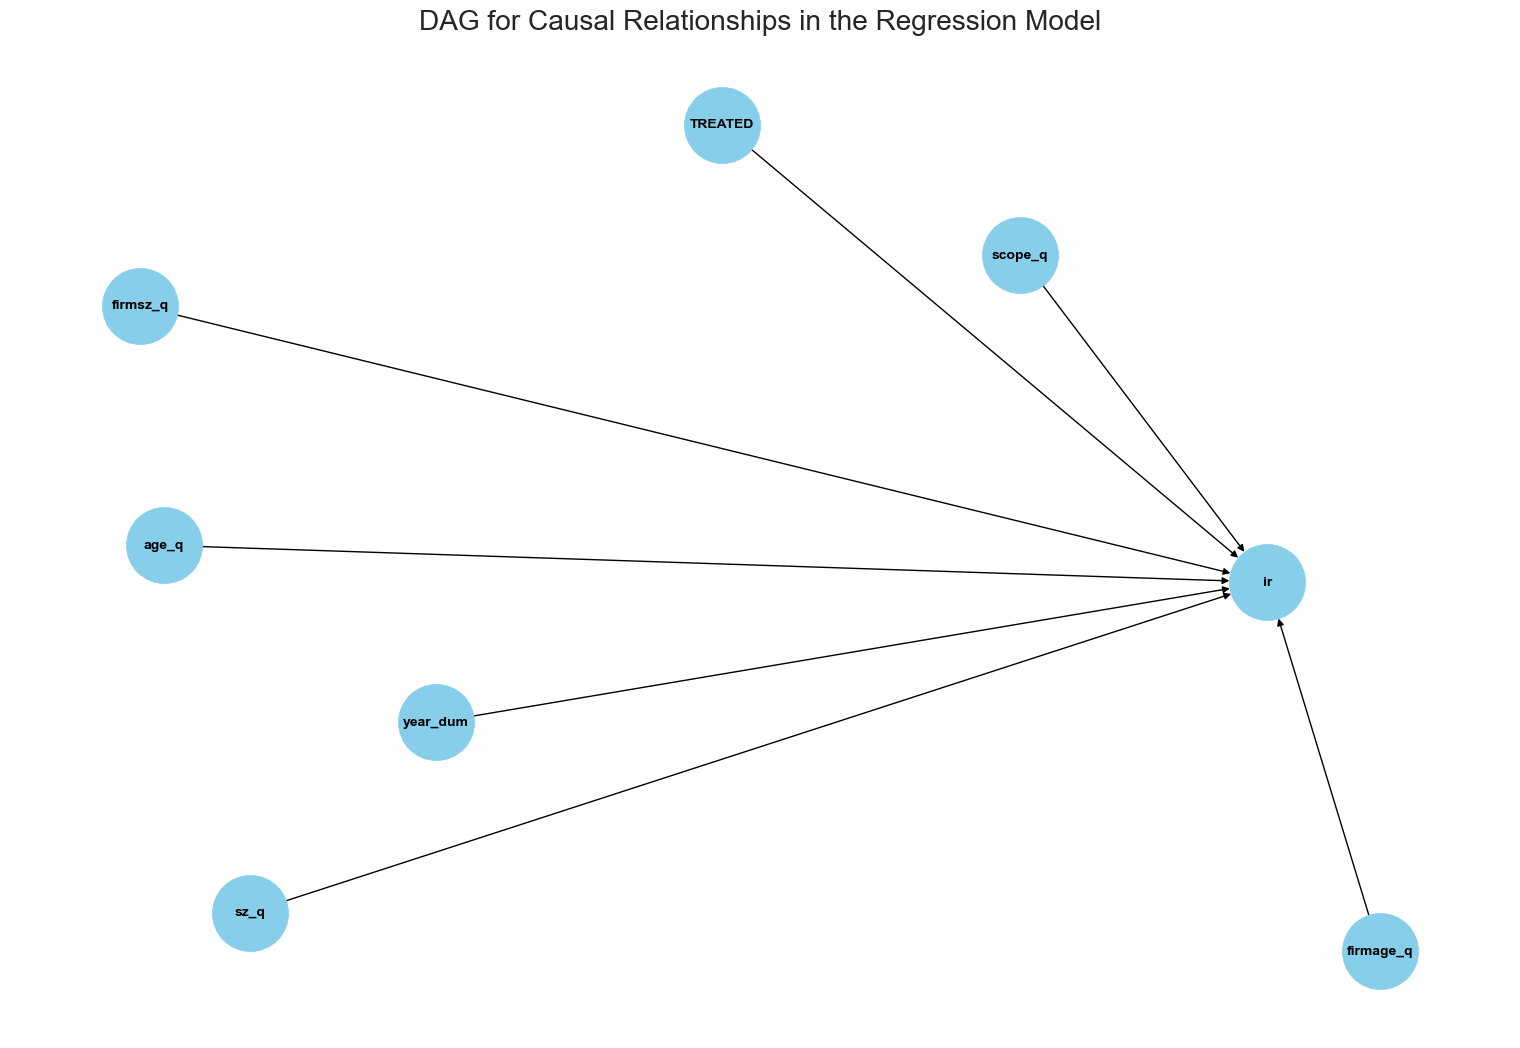

(array([-0.00613112]), array([-0.06657371]), array([0.05431148]))


In [14]:
import pandas as pd
import numpy as np
from causalml.inference.meta import LRSRegressor
import networkx as nx
import matplotlib.pyplot as plt

# Convert boolean columns to numeric (0 or 1)
boolean_columns = regression_df.select_dtypes(include='bool').columns
regression_df[boolean_columns] = regression_df[boolean_columns].astype(int)

# Ensure all columns used in the model are numeric
regression_df = regression_df.apply(pd.to_numeric, errors='coerce')

# Fill missing values with the mean of the column
regression_df = regression_df.fillna(regression_df.mean())

# Define the nodes (variables)
nodes = ['TREATED', 'ir'] + [f'sz_q'] + \
        [f'age_q'] + \
        [f'scope_q'] + \
        [f'firmsz_q'] + \
        [f'firmage_q'] + \
        [f'year_dum'] 

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
G.add_nodes_from(nodes)

# Add directed edges based on assumed causal relationships
# For example, TREATED is assumed to affect 'ir' directly
G.add_edge('TREATED', 'ir')

# Assume size, age, scope, firm size, and firm age affect 'ir'
for i in range(1):
    G.add_edge(f'sz_q', 'ir')
    G.add_edge(f'age_q', 'ir')
    G.add_edge(f'firmsz_q', 'ir')
    G.add_edge(f'firmage_q', 'ir')

for i in range(1):
    G.add_edge(f'scope_q', 'ir')

# Year dummies can be considered as control variables affecting 'ir'
for i in range(1):
    G.add_edge(f'year_dum', 'ir')


# Visualize the graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold')
plt.title('DAG for Causal Relationships in the Regression Model')
plt.show()

# Prepare data for causal inference
features = [f'sz_q{i}' for i in range(10)] + [f'age_q{i}' for i in range(10)] + \
           [f'scope_q{i}' for i in range(1, 5)] + [f'firmsz_q{i}' for i in range(10)] + \
           [f'firmage_q{i}' for i in range(10)] + [f'year_dum_{i}' for i in range(1996, 2008)] + \
           [f'year_dum_{i}' for i in range(2009, 2012)]

X = regression_df[features]
treatment = regression_df['TREATED']
outcome = regression_df['ir']

# Use a meta-learner for causal inference
learner = LRSRegressor()
learner.fit(X=X, treatment=treatment, y=outcome)

# Estimate treatment effects
te = learner.estimate_ate(X=X, treatment=treatment, y=outcome)
print(te)


In [15]:
te_point_estimate, te_lower_bound, te_upper_bound = learner.estimate_ate(X=X, treatment=treatment, y=outcome)

print("Average Treatment Effect (ATE) Estimate:")
print(f"Point Estimate: {te_point_estimate[0]}")
print(f"95% Confidence Interval: ({te_lower_bound[0]}, {te_upper_bound[0]})")

if te_lower_bound[0] <= 0 <= te_upper_bound[0]:
    print("The ATE is not statistically significant at the 95% confidence level.")
else:
    print("The ATE is statistically significant at the 95% confidence level.")


Average Treatment Effect (ATE) Estimate:
Point Estimate: -0.006131119779921845
95% Confidence Interval: (-0.06657371495040645, 0.05431147539056276)
The ATE is not statistically significant at the 95% confidence level.


SIMILARLY TO THE REGRESSION we will be simplifying the variables for increased significance:

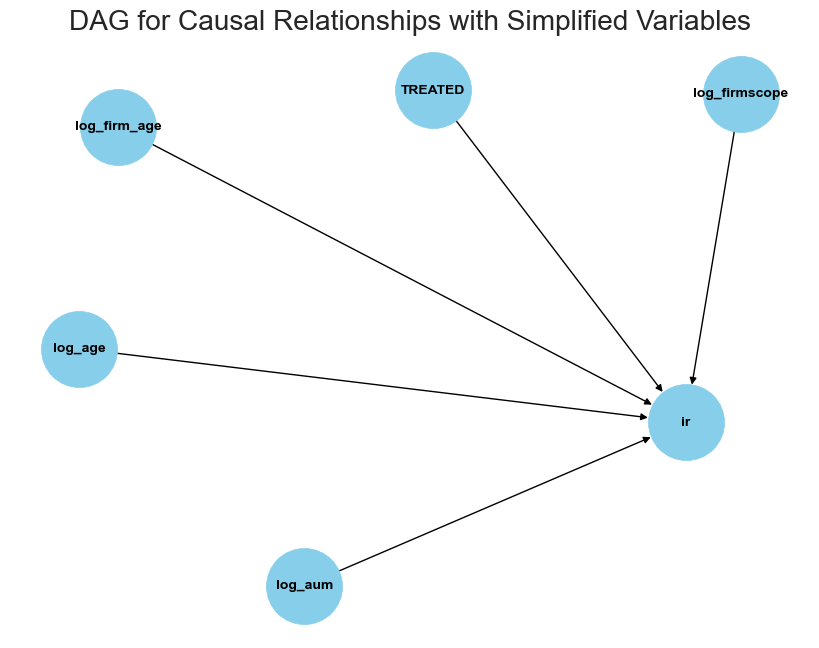

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the nodes (variables)
nodes = ['TREATED', 'ir', 'log_aum', 'log_age', 'log_firmscope', 'log_firm_age']

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
G.add_nodes_from(nodes)

# Add directed edges based on assumed causal relationships
# TREATED is assumed to affect 'ir' directly
G.add_edge('TREATED', 'ir')

# Size, age, scope, and firm age affect 'ir'
G.add_edge('log_aum', 'ir')
G.add_edge('log_age', 'ir')
G.add_edge('log_firmscope', 'ir')
G.add_edge('log_firm_age', 'ir')

# Visualize the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold')
plt.title('DAG for Causal Relationships with Simplified Variables')
plt.show()


In [18]:
# Prepare the simplified dataset
regression_df['log_aum'] = np.log(regression_df['aum_x'] + 1)  # Log transformation for aum to handle skewness
regression_df['log_age'] = np.log(regression_df['age'] + 1)  # Log transformation for age
regression_df['log_firmscope'] = np.log(regression_df['firmscope'] + 1)  # Log transformation for firm scope
regression_df['log_firm_age'] = np.log(regression_df['firm_age'] + 1)  # Log transformation for firm age



C:\Users\hendrikv\AppData\Local\Temp\ipykernel_17952\1439858755.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  regression_df['log_aum'] = np.log(regression_df['aum_x'] + 1)  # Log transformation for aum to handle skewness
C:\Users\hendrikv\AppData\Local\Temp\ipykernel_17952\1439858755.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  regression_df['log_firm_age'] = np.log(regression_df['firm_age'] + 1)  # Log transformation for firm age


In [19]:
import pandas as pd
from causalml.inference.meta import LRSRegressor

# Prepare data
X = regression_df[['log_aum', 'log_age', 'log_firmscope', 'log_firm_age']]
treatment = regression_df['TREATED']
outcome = regression_df['ir']

# Ensure there are no non-numeric values
X = X.apply(pd.to_numeric, errors='coerce')
treatment = treatment.apply(pd.to_numeric, errors='coerce')
outcome = outcome.apply(pd.to_numeric, errors='coerce')

# Check for and handle any remaining missing values
X = X.fillna(X.mean())
treatment = treatment.fillna(treatment.mean())
outcome = outcome.fillna(outcome.mean())

# Use a meta-learner for causal inference
learner = LRSRegressor()
learner.fit(X=X, treatment=treatment, y=outcome)

# Estimate treatment effects
te = learner.estimate_ate(X=X, treatment=treatment, y=outcome)
print("Average Treatment Effect (ATE) Estimate:")
print(f"Point Estimate: {te[0][0]}")
print(f"95% Confidence Interval: ({te[1][0]}, {te[2][0]})")

if te[1][0] <= 0 <= te[2][0]:
    print("The ATE is not statistically significant at the 95% confidence level.")
else:
    print("The ATE is statistically significant at the 95% confidence level.")


Average Treatment Effect (ATE) Estimate:
Point Estimate: -0.47890234013406807
95% Confidence Interval: (-0.5329716491378723, -0.4248330311302638)
The ATE is statistically significant at the 95% confidence level.


In [20]:
# Example robustness check using a different model specification

from causalml.inference.meta import XGBTRegressor

# Use a different meta-learner for causal inference
learner_xgb = XGBTRegressor()
learner_xgb.fit(X=X, treatment=treatment, y=outcome)

# Estimate treatment effects
te_xgb = learner_xgb.estimate_ate(X=X, treatment=treatment, y=outcome)
print("Average Treatment Effect (ATE) Estimate using XGBTRegressor:")
print(f"Point Estimate: {te_xgb[0][0]}")
print(f"95% Confidence Interval: ({te_xgb[1][0]}, {te_xgb[2][0]})")

if te_xgb[1][0] <= 0 <= te_xgb[2][0]:
    print("The ATE is not statistically significant at the 95% confidence level.")
else:
    print("The ATE is statistically significant at the 95% confidence level.")


Average Treatment Effect (ATE) Estimate using XGBTRegressor:
Point Estimate: -0.5199383482121115
95% Confidence Interval: (-0.5332666907048391, -0.5066100057193839)
The ATE is statistically significant at the 95% confidence level.
